## Transfer learning
## Whales vs Sharks

In [3]:
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy.linalg import norm
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
print(tf.__version__)

2.1.0


In [4]:
import utils
import os
import pathlib

import IPython.display as display
from PIL import Image

In [5]:
data_dir = './data'
data_path = pathlib.Path(data_dir)

### Всего было собрано 1137 изображений.
### Они были разбиты на обучающую и тестовую выборку:

In [6]:
image_count = len(list(data_path.glob('train/*/*.jpg')))
image_count

937

In [7]:
image_count = len(list(data_path.glob('test/*/*.jpg')))
image_count

200

In [8]:
image_widths = []
image_heights = []
whale_files = list(data_path.glob('*/*/whale*.jpg'))
shark_files = list(data_path.glob('*/*/shark*.jpg'))    

In [9]:
def autorotate(path):
    image = Image.open(path)
    (width, height) = image.size
    if height > width:
        image = image.rotate(90, expand=True)
        image.save(path, quality=100)

In [10]:
#for path in whale_files:    
#    autorotate(path)
#for path in shark_files:
#    autorotate(path)    

### Примеры изображений

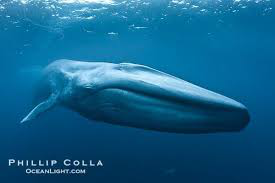

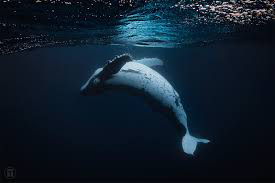

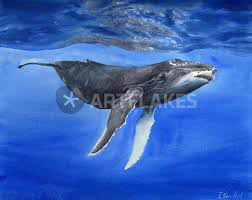

In [11]:
for image_path in whale_files[:3]:
    image = Image.open(str(image_path))
    display.display(image)

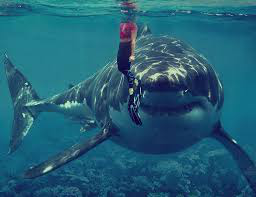

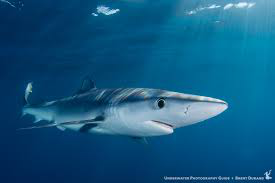

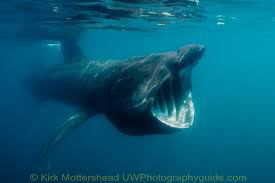

In [12]:
for image_path in shark_files[:3]:
    image = Image.open(str(image_path))
    display.display(image)

In [13]:
for image_path in whale_files:
    image = Image.open(str(image_path))
    image_size = image.size
    image_widths.append(image_size[0])
    image_heights.append(image_size[1])
for image_path in shark_files:
    image = Image.open(str(image_path))
    image_size = image.size
    image_widths.append(image_size[0])
    image_heights.append(image_size[1])    

### Все изображения имеют разные размеры. Статистика

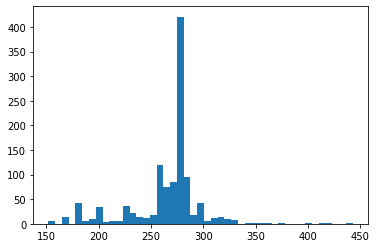

In [14]:
plt.hist(image_widths, bins=45);

In [15]:
stats.describe(image_widths)

DescribeResult(nobs=1137, minmax=(152, 443), mean=264.56992084432716, variance=1112.4143409268274, skewness=-0.7167576732049719, kurtosis=3.026114528539779)

In [16]:
np.median(image_widths)

275.0

In [17]:
stats.mode(image_widths)

ModeResult(mode=array([275]), count=array([344]))

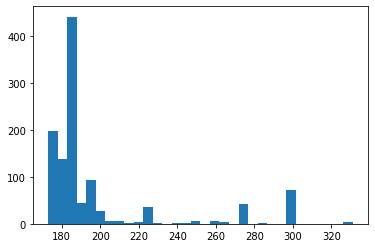

In [18]:
plt.hist(image_heights, bins=32);

In [19]:
stats.describe(image_heights)

DescribeResult(nobs=1137, minmax=(173, 331), mean=197.53474054529462, variance=1245.0307022433635, skewness=2.1448272333180123, kurtosis=3.2670719544961324)

In [20]:
np.median(image_heights)

183.0

In [21]:
stats.mode(image_heights)

ModeResult(mode=array([183]), count=array([370]))

### Все изображения приведём к одному размеру 183 x 183 пикселя.
### 183 - мода и медиана выборки высот изображений.

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = (183, 183)

In [19]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [20]:
CLASS_NAMES = np.array([item.name for item in data_path.glob('train/*')])
CLASS_NAMES

array(['shark', 'whale'], dtype='<U5')

In [92]:
train_generator = train_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    #class_mode='binary',
    classes=list(CLASS_NAMES),
    interpolation='bicubic'
)

Found 937 images belonging to 2 classes.


In [97]:
test_generator = test_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 200 images belonging to 2 classes.


In [98]:
STEPS_PER_EPOCH = train_generator.n // BATCH_SIZE
VALIDATION_STEPS = test_generator.n // BATCH_SIZE

In [99]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

### Пример батча обучающей выборки

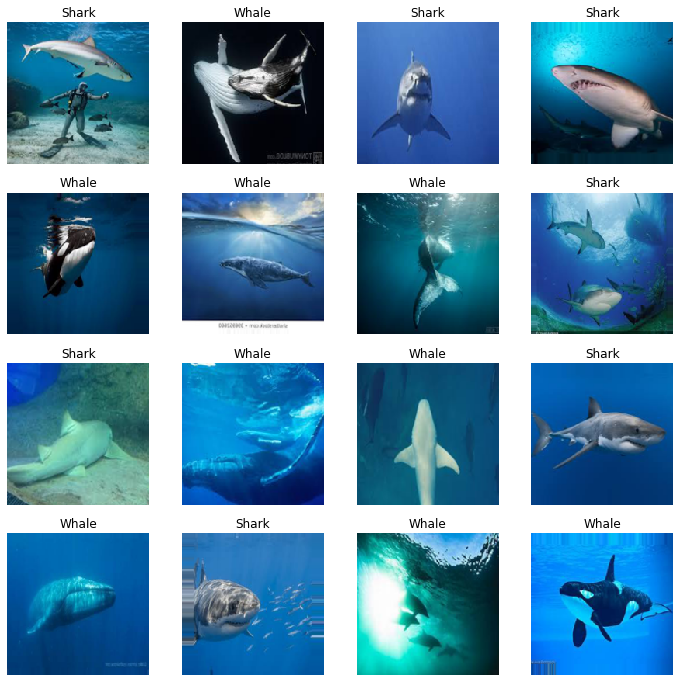

In [100]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [101]:
train_generator = train_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='bicubic'
)

Found 937 images belonging to 2 classes.


In [114]:
model = utils.make_model(img_shape=(183, 183, 3), num_classes=2)

### Составная модель на основе предобученной Inception ResNet v2

In [115]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 183, 183, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  multiple                  54336736  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                98368     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 54,435,234
Trainable params: 98,498
Non-trainable params: 54,336,736
_________________________________________

In [116]:
def extract_data_from_generator(generator, steps):
  images = list()
  labels = list()
  for (im, l), _ in zip(generator, range(steps)):
    images.append(im)
    labels.append(l)
  return np.concatenate(images), np.concatenate(labels)

In [117]:
images, labels = extract_data_from_generator(test_generator, VALIDATION_STEPS)

### Визуализация признаков, сформированных Inception ResNet
### Кластеры, соответствующие нашим двум классам, перемешаны.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.270122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.410412
[t-SNE] KL divergence after 900 iterations: 0.482061


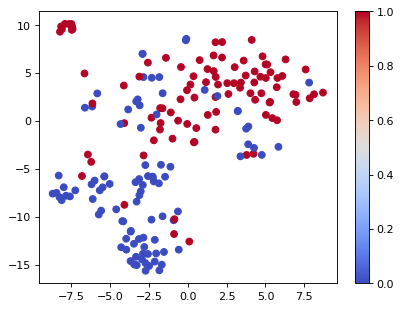

In [86]:
feature_extractor = utils.make_feature_extractor(model, 3)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        test_generator,
                        n_images_to_plot=0
                        )

In [118]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),    
    metrics=[keras.metrics.SparseCategoricalAccuracy()]    
)

In [119]:
monitor = 'val_loss'
early_stopping = keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=20,
    mode='min',
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=('model.h5'),
    monitor=monitor,
    save_best_only=True,
    mode='max'
)


callbacks = [early_stopping, checkpoint]

In [120]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=50,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=None
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 29 steps, validate for 6 steps
Epoch 1/50
29/29 [==============================] - 215s 7s/step - loss: 0.7139 - sparse_categorical_accuracy: 0.5315 - val_loss: 0.6317 - val_sparse_categorical_accuracy: 0.6042
Epoch 2/50
29/29 [==============================] - 203s 7s/step - loss: 0.6518 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.6302
Epoch 3/50
29/29 [==============================] - 201s 7s/step - loss: 0.5975 - sparse_categorical_accuracy: 0.6751 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.6927
Epoch 4/50
29/29 [==============================] - 201s 7s/step - loss: 0.5693 - sparse_categorical_accuracy: 0.7006 - val_loss: 0.7591 - val_sparse_categorical_accuracy: 0.6667
Epoch 5/50
29/29 [==============================] - 199s 7s/step - loss: 0.5388 - sparse_categorical_accuracy: 0.7260 - val_loss: 0.8950 - val_sparse_categorical_accuracy: 0.6510
Epoch 6/50
29/

In [121]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

### Обучение происходит. На обучающей выборке accuracy приблизилась к 90%.

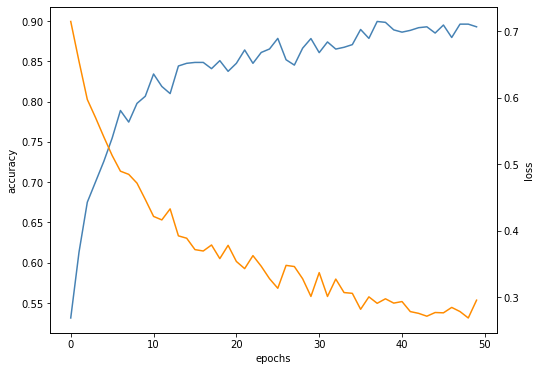

In [138]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx();
ax1.plot(history.history['loss'], color='darkorange')
ax1.set_ylabel('loss');

### На тестовой выборке accuracy не достигла и 80%.
### При этом значение функции потерь росло вместе с точностью распознавания, т.е. снижалась "уверенность" сети в правильности предсказаний.

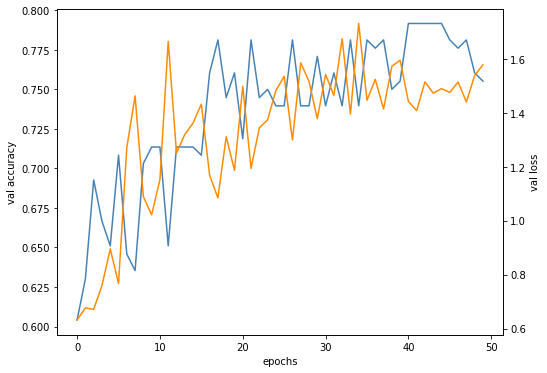

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['val_sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('val accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx()
ax1.plot(history.history['val_loss'], color='darkorange')
ax1.set_ylabel('val loss');

### Визуализация предсказаний составной сети на ОБУЧАЮЩЕЙ выборке.
### Выделились два кластера. Однако примеры обоих классов попали в оба кластера.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.790821
[t-SNE] KL divergence after 1000 iterations: 0.076301


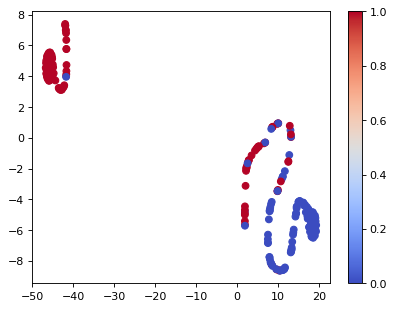

In [146]:
images, labels = extract_data_from_generator(train_generator, VALIDATION_STEPS)
feature_extractor = utils.make_feature_extractor(model, 0)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        train_generator,
                        n_images_to_plot=0
                        )

### Визуализация предсказаний составной сети на ТЕСТОВОЙ выборке.
### Разделение кластеров не произошло.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 168 samples in 0.005s...
[t-SNE] Computed neighbors for 168 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 168 / 168
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.606331
[t-SNE] KL divergence after 1000 iterations: 0.159162


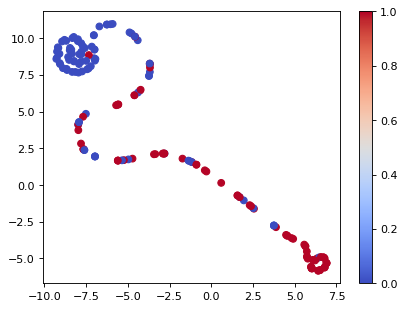

In [147]:
images, labels = extract_data_from_generator(test_generator, VALIDATION_STEPS)
feature_extractor = utils.make_feature_extractor(model, 0)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        test_generator,
                        n_images_to_plot=0
                        )